In [ ]:
from huggingface_hub import snapshot_download
import os

# Set your Hugging Face token here
hf_token = 'MY_TOKEN'

# Download the private repo
snapshot_download(
    repo_id="Gobi2005/medical-vit-cui-classifier",
    token=hf_token,
    local_dir="medical-vit-cui-classifier"
)


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

'/kaggle/working/medical-vit-cui-classifier'

In [37]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score
from skimage.feature import local_binary_pattern
import json
import ast
import random
import logging
from typing import List, Dict, Tuple, Any, Optional, Union
from transformers import PreTrainedModel, PretrainedConfig
from huggingface_hub import HfApi, create_repo, upload_folder, login
from datasets import load_dataset
import warnings
from tqdm import tqdm
import io


# 1. Load Model and Config
class ViTConfig(PretrainedConfig):
    """Configuration class for ViT model."""
    
    model_type = "vit_medical_cui"
    
    def __init__(
        self,
        num_labels: int = 100,
        model_name: str = "vit_base_patch16_224",
        **kwargs
    ):
        super().__init__(**kwargs)
        self.num_labels = num_labels
        self.model_name = model_name

class MedicalViTModel(PreTrainedModel):
    """Modified ViT model for 4-channel input and multi-label classification."""
    
    config_class = ViTConfig
    
    def __init__(self, config: ViTConfig):
        super().__init__(config)
        self.config = config
        
        # Load pretrained ViT
        self.vit = timm.create_model(
            config.model_name, 
            pretrained=True,
            num_classes=0  # Remove classification head
        )
        
        # Modify first conv layer for 4 channels
        original_conv = self.vit.patch_embed.proj
        self.vit.patch_embed.proj = nn.Conv2d(
            4,  # 4 input channels (RGB + LBP)
            original_conv.out_channels,
            kernel_size=original_conv.kernel_size,
            stride=original_conv.stride,
            padding=original_conv.padding,
            bias=original_conv.bias is not None
        )
        
        # Initialize new weights
        with torch.no_grad():
            # Copy RGB weights and average them for the 4th channel
            rgb_weights = original_conv.weight.data
            self.vit.patch_embed.proj.weight.data[:, :3, :, :] = rgb_weights
            self.vit.patch_embed.proj.weight.data[:, 3:4, :, :] = rgb_weights.mean(dim=1, keepdim=True)
        
        # Add classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.vit.num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, config.num_labels)
        )
        
    def forward(
        self, 
        pixel_values: torch.Tensor, 
        labels: Optional[torch.Tensor] = None
    ) -> Dict[str, torch.Tensor]:
        # Extract features using ViT
        features = self.vit(pixel_values)
        
        # Classification
        logits = self.classifier(features)
        
        output = {"logits": logits}
        
        if labels is not None:
            loss_fn = nn.BCEWithLogitsLoss()
            loss = loss_fn(logits, labels)
            output["loss"] = loss
            
        return output

class MedicalImageTrainer:
    """Trainer class for medical image classification."""

    def __init__(
        self,
        model,
        train_loader: DataLoader,
        val_loader: DataLoader,
        device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
        logger: Optional[logging.Logger] = None,
        checkpoint_dir: str = "./checkpoints",
        threshold: float = 0.5,
        grad_accum_steps: int = 1,
        early_stop_patience: int = 3,
        use_amp: bool = True,
    ):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.logger = logger or logging.getLogger(__name__)
        self.checkpoint_dir = checkpoint_dir
        self.threshold = threshold
        self.grad_accum_steps = grad_accum_steps
        self.early_stop_patience = early_stop_patience
        self.use_amp = use_amp and (device != 'cpu')  # AMP only on GPU

        os.makedirs(checkpoint_dir, exist_ok=True)

        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=3e-5,
            weight_decay=0.01
        )
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer,
            T_max=len(train_loader) * 10  # Assuming 10 epochs
        )

        self.scaler = torch.amp.GradScaler() if self.use_amp else None

        self.train_losses = []
        self.val_losses = []
        self.val_metrics = []
        self.best_f1 = 0.0

        self.early_stop_counter = 0

    def train_epoch(self) -> float:
        """Train for one epoch."""
        self.model.train()
        total_loss = 0.0
        num_batches = len(self.train_loader)
        self.optimizer.zero_grad()

        pbar = tqdm(total=num_batches, desc="Training", leave=False)

        for batch_idx, (images, labels) in enumerate(self.train_loader):
            images, labels = images.to(self.device), labels.to(self.device)

            if self.use_amp:
                with torch.amp.autocast(device_type=self.device):
                    outputs = self.model(pixel_values=images, labels=labels)
                    loss = outputs["loss"] / self.grad_accum_steps
                self.scaler.scale(loss).backward()
            else:
                outputs = self.model(pixel_values=images, labels=labels)
                loss = outputs["loss"] / self.grad_accum_steps
                loss.backward()

            if (batch_idx + 1) % self.grad_accum_steps == 0 or (batch_idx + 1) == num_batches:
                if self.use_amp:
                    self.scaler.step(self.optimizer)
                    self.scaler.update()
                else:
                    self.optimizer.step()
                self.scheduler.step()
                self.optimizer.zero_grad()

            total_loss += loss.item() * self.grad_accum_steps  # multiply back for logging

            pbar.update(1)
            pbar.set_postfix({'Loss': f'{loss.item() * self.grad_accum_steps:.4f}'})

            if batch_idx % 10 == 0:
                self.logger.info(f'Batch {batch_idx}/{num_batches}, Loss: {loss.item() * self.grad_accum_steps:.4f}')

        pbar.close()
        avg_loss = total_loss / num_batches
        self.train_losses.append(avg_loss)
        return avg_loss

    def validate(self) -> Dict[str, float]:
        """Validate the model."""
        self.model.eval()
        total_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in self.val_loader:
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model(pixel_values=images, labels=labels)
                loss = outputs["loss"]

                total_loss += loss.item()

                preds = torch.sigmoid(outputs["logits"]) > self.threshold
                all_preds.append(preds.cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)

        precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        avg_loss = total_loss / len(self.val_loader)
        self.val_losses.append(avg_loss)

        metrics = {
            'val_loss': avg_loss,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
        self.val_metrics.append(metrics)

        # Save checkpoint if F1 improved
        if f1 > self.best_f1:
            self.best_f1 = f1
            self.save_checkpoint(metrics, is_best=True)
            self.logger.info(f"New best F1 score: {f1:.4f} - Model checkpoint saved")
            self.early_stop_counter = 0
        else:
            self.early_stop_counter += 1

        return metrics

    def save_checkpoint(self, metrics: Dict[str, float], is_best: bool = False) -> None:
        """Save model checkpoint."""
        checkpoint = {
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'metrics': metrics,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'val_metrics': self.val_metrics
        }

        if is_best:
            checkpoint_path = os.path.join(self.checkpoint_dir, 'best_model.pt')
        else:
            checkpoint_path = os.path.join(self.checkpoint_dir, 'latest_model.pt')

        torch.save(checkpoint, checkpoint_path)

    def save_training_history(self, filepath: str = "./training_history.json") -> None:
        """Save training history to JSON file."""
        history = {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'val_metrics': self.val_metrics,
            'best_f1_score': self.best_f1
        }

        with open(filepath, 'w') as f:
            json.dump(history, f, indent=2)

        self.logger.info(f"Training history saved to {filepath}")

    def train(self, num_epochs: int = 10) -> None:
        """Full training loop."""
        self.logger.info(f"Training on {self.device}")

        for epoch in range(num_epochs):
            self.logger.info(f"\nEpoch {epoch+1}/{num_epochs}")
            self.logger.info("-" * 50)

            # Train
            train_loss = self.train_epoch()
            self.logger.info(f"Training Loss: {train_loss:.4f}")

            # Log current LR
            current_lr = self.optimizer.param_groups[0]['lr']
            self.logger.info(f"Learning Rate: {current_lr:.6f}")

            # Validate
            val_metrics = self.validate()
            self.logger.info(f"Validation Loss: {val_metrics['val_loss']:.4f}")
            self.logger.info(f"Precision: {val_metrics['precision']:.4f}")
            self.logger.info(f"Recall: {val_metrics['recall']:.4f}")
            self.logger.info(f"F1-Score: {val_metrics['f1_score']:.4f}")

            # Early stopping check
            if self.early_stop_counter >= self.early_stop_patience:
                self.logger.info(f"Early stopping triggered after {self.early_stop_patience} epochs with no improvement.")
                break

        # Save final training history
        self.save_training_history()



In [35]:
#import os
#os.rename('medical-vit-cui-classifier','model')

OSError: [Errno 39] Directory not empty: 'medical-vit-cui-classifier' -> 'model'

In [38]:
import json
from safetensors.torch import load_file

# Load config with correct num_labels (MUST match the model that saved the weights)
with open("model/config.json", "r") as f:
    cfg_dict = json.load(f)

# This config should say "num_labels": 19
cfg_dict["num_labels"] = 19


# Build model
config = ViTConfig(**cfg_dict)
model = MedicalViTModel(config)

# Load weights safely
state_dict = load_file("model/model.safetensors")
missing_keys, unexpected_keys = model.load_state_dict(state_dict, strict=False)

print("✅ Model loaded.")
print("Missing keys:", missing_keys)
print("Unexpected keys:", unexpected_keys)

model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 2. Load CUI class names
with open("model/cui_classes.json", "r") as f:
    cui_classes = json.load(f)["classes"]




✅ Model loaded.
Missing keys: []
Unexpected keys: []


In [39]:
cui_to_index = {c: i for i, c in enumerate(cui_classes)}
print(cui_to_index)

{'C0000726': 0, 'C0002978': 1, 'C0006141': 2, 'C0023216': 3, 'C0024485': 4, 'C0030797': 5, 'C0032743': 6, 'C0037303': 7, 'C0037949': 8, 'C0040405': 9, 'C0041618': 10, 'C0205106': 11, 'C0205129': 12, 'C0817096': 13, 'C1140618': 14, 'C1306645': 15, 'C1996865': 16, 'C1999039': 17, 'nan': 18}


In [ ]:
import os
from datasets import load_dataset

def load_and_save_test_dataset(
    repo_id: str = "eltorio/ROCOv2-radiology",
    save_dir: str = "dataset"
):
    test_dir = os.path.join(save_dir, "test")
    os.makedirs(test_dir, exist_ok=True)

    print("Loading test data...")
    test_ds = load_dataset(repo_id, split="test")
    test_save_path = os.path.join(test_dir, "test_dataset.parquet")
    test_ds.to_parquet(test_save_path)
    print(f"Saved test dataset to {test_save_path}")

    print("✅ Test dataset loading and saving complete.")
    return test_ds

#load_and_save_test_dataset()

In [40]:
!wget https://huggingface.co/datasets/eltorio/ROCOv2-radiology/resolve/main/data/test-00001-of-00006.parquet

--2025-06-04 05:56:11--  https://huggingface.co/datasets/eltorio/ROCOv2-radiology/resolve/main/data/test-00001-of-00006.parquet
Resolving huggingface.co (huggingface.co)... 18.244.202.60, 18.244.202.68, 18.244.202.73, ...
Connecting to huggingface.co (huggingface.co)|18.244.202.60|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/0c/b0/0cb0f6820132af26830970ad86609d1f6804b03c7dd65ababd05546d4cbdab40/880a9a3fba293bd4d52a8c5553af3b5f27def29ce117b78ce72e3dee6560dce1?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27test-00001-of-00006.parquet%3B+filename%3D%22test-00001-of-00006.parquet%22%3B&Expires=1749020171&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0OTAyMDE3MX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzBjL2IwLzBjYjBmNjgyMDEzMmFmMjY4MzA5NzBhZDg2NjA5ZDFmNjgwNGIwM2M3ZGQ2NWFiYWJkMDU1NDZkNGNiZGFiNDAvODgwYTlhM2ZiYTI5M2JkNGQ1MmE4YzU1NTNhZjNiNWYyN2RlZjI

In [41]:
class ParquetImageDataset(Dataset):
    def __init__(self, parquet_path, transform_size=(224, 224)):
        self.df = pd.read_parquet(parquet_path)
        self.size = transform_size
        self.mean = [0.485, 0.456, 0.406, 0.5]
        self.std = [0.229, 0.224, 0.225, 0.25]

    def __len__(self):
        return len(self.df)

    def preprocess_image(self, image_bytes: bytes) -> torch.Tensor:
        image = Image.open(io.BytesIO(image_bytes)).convert('RGB')
        img_array = np.array(image)
        gray = np.dot(img_array[..., :3], [0.299, 0.587, 0.114])
        gray_uint8 = np.clip(gray, 0, 255).astype(np.uint8)
        lbp = local_binary_pattern(gray_uint8, P=24, R=3, method='uniform')

        if lbp.max() > lbp.min():
            lbp_norm = ((lbp - lbp.min()) / (lbp.max() - lbp.min()) * 255).astype(np.uint8)
        else:
            lbp_norm = np.zeros_like(lbp, dtype=np.uint8)

        img_4ch = np.dstack([img_array, lbp_norm])
        img_4ch = Image.fromarray(img_4ch.astype(np.uint8)).resize(self.size)

        img_tensor = torch.from_numpy(np.array(img_4ch)).permute(2, 0, 1).float() / 255.0
        for i in range(4):
            img_tensor[i] = (img_tensor[i] - self.mean[i]) / self.std[i]
        return img_tensor

    def __getitem__(self, idx):
        image_bytes = self.df.loc[idx, 'image']['bytes']
        img_tensor = self.preprocess_image(image_bytes)
        
        # Parse labels
        try:
            raw = self.df.loc[idx, 'cui']
            labels = eval(raw) if isinstance(raw, str) else raw
            label_vec = torch.zeros(len(cui_classes))
            for cui in labels:
                if cui in cui_to_index:
                    label_vec[cui_to_index[cui]] = 1
        except:
            label_vec = torch.zeros(len(cui_classes))

        return img_tensor, label_vec, idx

# ---------- 3. Inference in Batches ----------
parquet_path = "/kaggle/working/test-00001-of-00006.parquet"
dataset = ParquetImageDataset(parquet_path)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False, num_workers=2)

from tqdm import tqdm

# Inference on all images (batched with tqdm)
all_preds, all_labels, all_indices = [], [], []

with torch.no_grad():
    for images, labels, indices in tqdm(dataloader, desc="Running Inference", total=len(dataloader)):
        images = images.to(device)
        outputs = model(pixel_values=images)
        probs = torch.sigmoid(outputs["logits"]) > 0.5
        all_preds.append(probs.cpu())
        all_labels.append(labels)
        all_indices.extend(indices.tolist())


all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# ---------- 4. Evaluation ----------
precision = precision_score(all_labels, all_preds, average="macro", zero_division=0)
recall = recall_score(all_labels, all_preds, average="macro", zero_division=0)
f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

print(f"✅ Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

# ---------- 5. Save Predictions ----------
df = pd.read_parquet(parquet_path)
predictions = []

for i, idx in enumerate(all_indices):
    pred_labels = [cui_classes[j] for j in np.where(all_preds[i] == 1)[0]]
    true_labels = [cui_classes[j] for j in np.where(all_labels[i] == 1)[0]]
    predictions.append({
        "index": int(idx),
        "predicted_cuis": pred_labels,
        "true_cuis": true_labels
    })

# Save to JSON
with open("predictions.json", "w") as f:
    json.dump(predictions, f, indent=2)

# Save to CSV
pred_df = pd.DataFrame(predictions)
pred_df.to_csv("predictions.csv", index=False)

print("📁 Saved predictions to predictions.json and predictions.csv")

Running Inference: 100%|██████████| 104/104 [10:52<00:00,  6.27s/it]


✅ Precision: 0.8451, Recall: 0.7631, F1: 0.7860
📁 Saved predictions to predictions.json and predictions.csv


In [42]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Per-class metrics
per_class_precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
per_class_recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
per_class_f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)

metrics_df = pd.DataFrame({
    "CUI": cui_classes,
    "Precision": per_class_precision,
    "Recall": per_class_recall,
    "F1-Score": per_class_f1
})
metrics_df.to_csv("per_class_metrics.csv", index=False)
print("📊 Saved per-class metrics to per_class_metrics.csv")


📊 Saved per-class metrics to per_class_metrics.csv


In [43]:
from sklearn.metrics import multilabel_confusion_matrix

mcm = multilabel_confusion_matrix(all_labels, all_preds)
conf_matrix_summary = []

for i, cui in enumerate(cui_classes):
    tn, fp, fn, tp = mcm[i].ravel()
    conf_matrix_summary.append({
        "CUI": cui,
        "TP": int(tp),
        "FP": int(fp),
        "FN": int(fn),
        "TN": int(tn)
    })

conf_df = pd.DataFrame(conf_matrix_summary)
conf_df.to_csv("confusion_matrix_per_class.csv", index=False)
print("📊 Saved multilabel confusion matrix to confusion_matrix_per_class.csv")


📊 Saved multilabel confusion matrix to confusion_matrix_per_class.csv


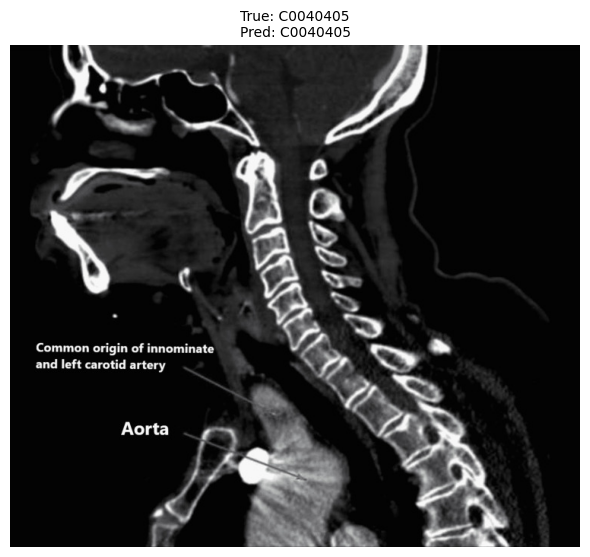

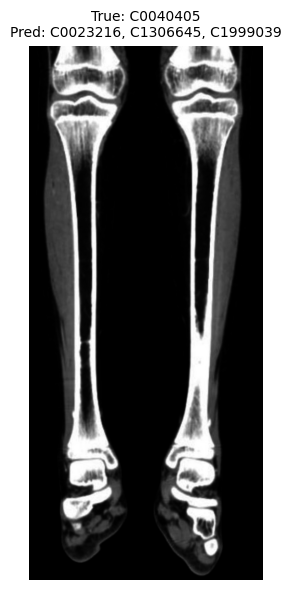

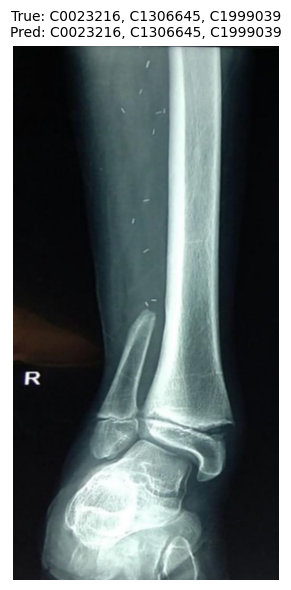

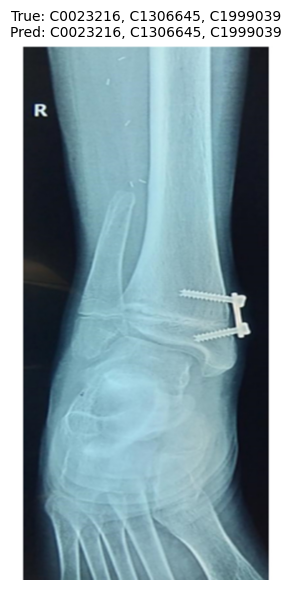

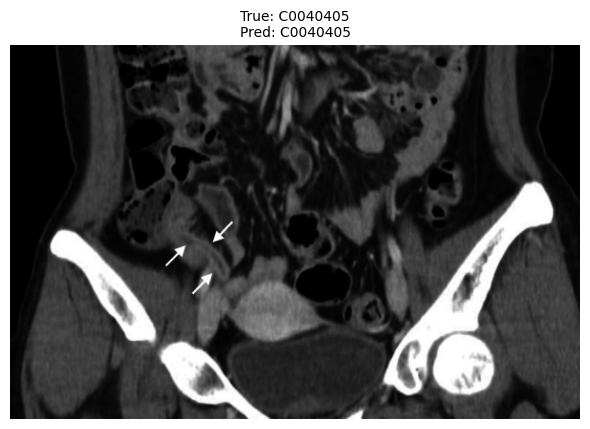

In [44]:
import matplotlib.pyplot as plt

# Reload parquet for access to image bytes
df = pd.read_parquet(parquet_path)

for i in range(5):  # Show first 5 images
    idx = all_indices[i]
    row = df.iloc[idx]
    image_bytes = row['image']['bytes']
    image = Image.open(io.BytesIO(image_bytes)).convert('RGB')

    pred_labels = [cui_classes[j] for j in np.where(all_preds[i] == 1)[0]]
    true_labels = [cui_classes[j] for j in np.where(all_labels[i] == 1)[0]]

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"True: {', '.join(true_labels)}\nPred: {', '.join(pred_labels)}", fontsize=10)
    plt.tight_layout()
    plt.savefig(f"prediction_vis_{i}.png")  # Saves each image
    plt.show()
